In [1]:
import tqdm
import torch.nn as nn
import torch
from torch.optim import SGD
from torch.optim import RMSprop
from torch.optim import Adam
import math
import numpy as np
import csv
import matplotlib.pyplot as plt
import torch.utils.tensorboard as tensorboard
from torch.autograd import Variable  
import datetime

In [2]:
#1時間ごとでの
with open('2022_nikkei_225.csv') as f:
    reader = csv.reader(f)
    l = [row for row in reader]
    test = [int(l[1][2]) for i in range(2, len(l))]
    minuites_data = [int(l[i][2]) for i in range(2, len(l))]
    m_data = np.array(minuites_data)

In [3]:
def normalization(data):
    avg = np.mean(data)
    std = np.std(data)
    data = (data - avg) / std
    return data

In [4]:
m_data = normalization(m_data)

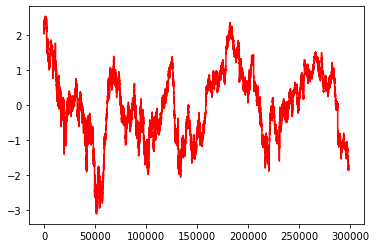

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(m_data, color = "r")

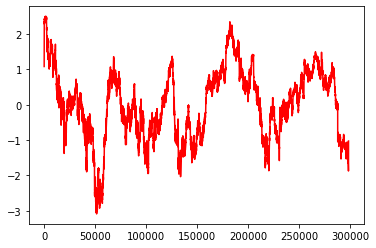

In [6]:
window = 10 # 移動平均の範囲
w = np.ones(window)/window

m_data_convolve = np.convolve(m_data, w, mode='same')

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(m_data_convolve, color = "r")

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [8]:
def value_s(np_array, rate = 0.9):
    sum = 0
    if (len(np_array) < 100):
        for n, r in enumerate(np_array):
            sum += rate ** n * (r - np_array[0])
    else:
        for n in range(100):
            sum += rate ** n * (np_array[n] - np_array[0])
    return sum

def mkDataSet(data_size, data_length):
    train_x = []
    train_t = []
    freq=60.
    for offset in range(data_size // 100):
        train_x.append([[m_data_convolve[offset * 100 + i]] for i in range(data_length)])
        train_t.append([value_s(m_data_convolve[offset * 100 + data_length:-1])])
        
    return np.array(train_x), np.array(train_t)

def mkBatchSet(train_x, train_t, batch_size):
    batch_x = []
    batch_t = []    
    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x)-1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
        
    batch_x = np.array(batch_x).astype(np.float32)
    batch_t = np.array(batch_t).astype(np.float32)

    return torch.from_numpy(batch_x).clone().reshape(batch_size, 1, -1).to(device), torch.from_numpy(batch_t).clone().to(device)

In [13]:
data_length = 10000
training_size = len(m_data)-data_length
epoch_num = 100000
hidden_size = 10
batch_size = 32

train_x, train_t = mkDataSet(training_size, data_length)
data, label = mkBatchSet(train_x, train_t, batch_size)

In [14]:
class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()
        self.hiddenDim = hiddenDim
        self.kernel_size1 = 5000
        self.kernel_size2 = 2500
        self.kernel_size3 = 500
        self.kernel_size4 = 250
        self.kernel_size5 = 100
        self.kernel_size6 = 50
        self.seq_len = ((inputDim - self.kernel_size1 + 1 - self.kernel_size2 + 1) // 2 - self.kernel_size3 + 1 - self.kernel_size4 + 1) // 2 - self.kernel_size5 + 1 - self.kernel_size6 + 1
        
        self.conv1d_1 = nn.Conv1d(1, 16, self.kernel_size1)
        self.conv1d_2 = nn.Conv1d(16, 32, self.kernel_size2)
        self.max_pool1 = nn.MaxPool1d(2)
        self.conv1d_3 = nn.Conv1d(32, 64, self.kernel_size3)
        self.conv1d_4 = nn.Conv1d(64, 64, self.kernel_size4)
        self.max_pool2 = nn.MaxPool1d(2)
        self.conv1d_5 = nn.Conv1d(64, 64, self.kernel_size5)
        self.conv1d_6 = nn.Conv1d(64, 64, self.kernel_size6)
        self.rnn1 = nn.LSTM(input_size=64, hidden_size=hiddenDim, batch_first=True) #batch_first=Trueで(seq, batch, vec)->(batch, seq, vec)に入力の形を変更
        self.rnn2 = nn.LSTM(input_size=hiddenDim, hidden_size=hiddenDim, batch_first=True) #batch_first=Trueで(seq, batch, vec)->(batch, seq, vec)に入力の形を変更
        self.output_layer = nn.Linear(hiddenDim, outputDim)

    def forward(self, input):
        output = self.conv1d_1(input)
        output = self.conv1d_2(output)
        output = self.maxpool1(output)
        output = self.conv1d_3(output)
        output = self.conv1d_4(output)
        output = self.maxpool2(output)
        output = self.conv1d_5(output)
        output = self.conv1d_6(output)
        h_0_1 = None
        output = output.reshape(-1, self.seq_len, 64)
        output, (hidden, cell) = self.rnn1(output, (h_0_1)) #LSTMのforwardのreturnはこのような戻り値になっている
        h_0_2 = None
        output, (hidden, cell) = self.rnn2(output, (h_0_2))
        output = self.output_layer(output[:, -1, :]) #LSTMのoutput=(batch, seq, hidden)からseqのみ最後のやつだけを取り出す
        return output

In [15]:
model = Predictor(data_length, hidden_size, 1).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [20]:
loss_history = []
for epoch in tqdm.tqdm(range(epoch_num)):
    optimizer.zero_grad()
    data, label = mkBatchSet(train_x, train_t, batch_size)
    output = model(data)

    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    running_loss = torch.sum(loss.data)
    loss_history.append(running_loss.to('cpu').detach().numpy().copy())
    
    if (epoch+1) % 1000 == 0:
        print('%d loss: %3f' % (epoch+1, running_loss))

  1% 1000/100000 [03:26<5:42:41,  4.81it/s]

1000 loss: 0.080435


  2% 2000/100000 [06:54<5:38:36,  4.82it/s]

2000 loss: 0.050720


  3% 3000/100000 [10:21<5:35:20,  4.82it/s]

3000 loss: 0.042026


  5% 5000/100000 [17:16<5:28:19,  4.82it/s]

5000 loss: 0.027643


  6% 6000/100000 [20:44<5:25:00,  4.82it/s]

6000 loss: 0.029499


  7% 7000/100000 [24:11<5:21:22,  4.82it/s]

7000 loss: 0.042686


  7% 7184/100000 [24:49<5:20:48,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 20% 20000/100000 [1:09:09<4:36:39,  4.82it/s]

20000 loss: 0.057178


 21% 21000/100000 [1:12:37<4:33:28,  4.81it/s]

21000 loss: 0.026908


 22% 22000/100000 [1:16:04<4:29:27,  4.82it/s]

22000 loss: 0.017223


 23% 22668/100000 [1:18:23<4:27:17,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 36% 36000/100000 [2:04:28<3:41:13,  4.82it/s]

36000 loss: 0.042487


 37% 37000/100000 [2:07:56<3:37:28,  4.83it/s]

37000 loss: 0.045951


 38% 38000/100000 [2:11:23<3:34:14,  4.82it/s]

38000 loss: 0.119839


 38% 38171/100000 [2:11:59<3:33:32,  4.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 50% 50000/100000 [2:52:52<2:52:52,  4.82it/s]

50000 loss: 0.031152


 51% 51000/100000 [2:56:19<2:49:29,  4.82it/s]

51000 loss: 0.019911


 52% 52000/100000 [2:59:47<2:45:39,  4.83it/s]

52000 loss: 0.016257


 53% 52840/100000 [3:02:41<2:42:51,  4.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 66% 66000/100000 [3:48:10<1:57:31,  4.82it/s]

66000 loss: 0.020638


 67% 67000/100000 [3:51:37<1:54:03,  4.82it/s]

67000 loss: 0.024116


 68% 68000/100000 [3:55:05<1:50:34,  4.82it/s]

68000 loss: 0.021763


 68% 68312/100000 [3:56:09<1:49:30,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 81% 81000/100000 [4:40:02<1:05:42,  4.82it/s]

81000 loss: 0.015075


 82% 82000/100000 [4:43:29<1:02:12,  4.82it/s]

82000 loss: 0.032632


 83% 83000/100000 [4:46:57<58:50,  4.82it/s]  

83000 loss: 0.013016


 84% 83562/100000 [4:48:53<56:48,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 96% 96000/100000 [5:31:52<13:48,  4.83it/s]

96000 loss: 0.016444


 97% 97000/100000 [5:35:20<10:22,  4.82it/s]

97000 loss: 0.029470


 98% 98000/100000 [5:38:47<06:54,  4.83it/s]

98000 loss: 0.030339


 99% 98714/100000 [5:41:15<04:26,  4.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



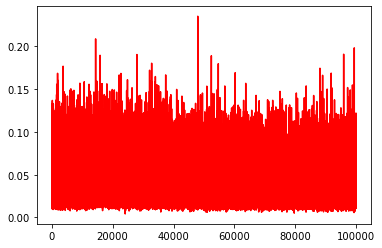

In [23]:
loss_history = np.array(loss_history)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(loss_history, color = "r")

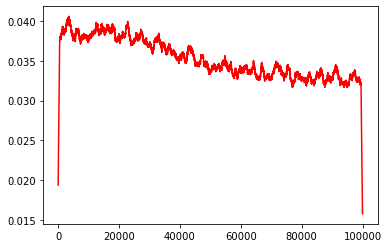

In [28]:
window = 1000 # 移動平均の範囲
w = np.ones(window)/window

loss_hist_convolve = np.convolve(loss_history, w, mode='same')

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(loss_hist_convolve, color = "r")

In [81]:
def mkValidDataSet(valid_data_size, data_length, idx):
    train_x = []
    train_t = []
    
    for offset in range(valid_data_size):
        train_x.append([[m_data_convolve[idx + offset]] for i in range(data_length)])
        
    return np.array(train_x)

In [ ]:
valid_data_size = 10000
reward_avg = 0.

with torch.no_grad():
    for _ in range(10):
        state = 1 #0->1で売り　1->0で買い
        reward = 0.
        last_output = 0.
        buy_chart = 0.
        vs_history = []
        idx = int(np.random.randint(0, len(m_data_convolve) - valid_data_size - 1))
        test_data = mkValidDataSet(valid_data_size, data_length, idx)
        for data in tqdm.tqdm(test_data):
            output = model(torch.from_numpy(data.astype(np.float32)).clone().reshape(1, 1, -1).to(device))
            if output.data > last_output:
                if state == 0:
                    reward += data[-1][0] - buy_chart
                state = 1
            else:
                if state == 1:
                    buy_chart = data[-1][0]
                state = 0
            vs_history.append(np.squeeze(output.data.to('cpu').detach().numpy().copy()))
            last_output = output.data
        
        vs_history = np.array(vs_history)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(vs_history, color = "r")
        
        print(reward)
        reward_avg += reward
print(reward_avg)

In [ ]:
# def mkRandomBatch(train_x, train_t, batch_size=10):
#     batch_x = []
#     batch_t = []
    
#     for _ in range(batch_size):
#         idx = np.random.randint(0, len(train_x)-1)
#         batch_x.append(train_x[idx])
#         batch_t.append(train_t[idx])
    
#     return torch.tensor(batch_x), torch.tensor(batch_t)

In [ ]:
# batch_size = 10

# for epoch in range(epoch_num):
#     running_loss = 0.0
#     last_training_accuracy = 0.0
#     correct = 0.0
#     for i in range(int(training_size / batch_size)):
#         optimizer.zero_grad()
#         data, label = mkRandomBatch(train_x, train_t, batch_size)

#         output = model(data)

#         loss = criterion(output, label)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.data
#         correct += np.sum(np.abs((output.data - label.data).numpy()) < 0.1)
    
#     training_accuracy = correct / training_size
#     print('%d loss: %3f, training_accuracy: %.5f' % (epoch+1, running_loss, training_accuracy))
#     if last_training_accuracy > training_accuracy:
#         break
#     last_training_accuracy = training_accuracy